<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/M2Det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2Det
https://qiita.com/BIG_LARGE_STONE/items/c7f4c9ad88488af13344

<table class="tfo-notebook-buttons" align="left" >
 <td>
<img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
  <td>
<img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
  </td>
</table>


In [1]:
!pip install torch
!pip install torchvision
!pip install cython
!pip install opencv-python
!pip install tqdm

In [2]:
!git clone https://github.com/qijiezhao/M2Det.git

Cloning into 'M2Det'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 226 (delta 47), reused 201 (delta 47), pack-reused 25
Receiving objects: 100% (226/226), 3.32 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
%cd M2Det

/content/M2Det


In [0]:
!sh make.sh > /dev/null

In [0]:
!mkdir weights

In [6]:
%cd weights/

/content/M2Det/weights


In [8]:
%env FILE_ID=1NM1UDdZnwHwiNDxhcP-nndaWj24m-90L
%env FILE_NAME=m2det512_vgg.pth
!curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=$FILE_ID" > /dev/null
!curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=$(awk '/_warning_/ {print $NF}' /tmp/cookie)&id=$FILE_ID" -o $FILE_NAME

env: FILE_ID=1NM1UDdZnwHwiNDxhcP-nndaWj24m-90L
env: FILE_NAME=m2det512_vgg.pth
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   3233      0 --:--:-- --:--:-- --:--:--  3260
100  506M    0  506M    0     0   112M      0 --:--:--  0:00:04 --:--:--  123M


In [9]:
ls -la

total 518560
drwxr-xr-x 2 root root      4096 Mar 11 10:14 ./
drwxr-xr-x 9 root root      4096 Mar 11 10:14 ../
-rw-r--r-- 1 root root 530996973 Mar 11 10:14 m2det512_vgg.pth


In [10]:
%cd ..

/content/M2Det


In [11]:
!pip install addict

  Stored in directory: /root/.cache/pip/wheels/1c/35/37/7a99ee58a72dc257689fb4f99c8018c9513555055e3fb87123
Successfully built addict


In [12]:
!python demo.py -c=configs/m2det512_vgg.py -m=weights/m2det512_vgg.pth --show

 ----------------------------------------------------------------------
|                       M2Det Demo Program                             |
 ----------------------------------------------------------------------
The Anchor info: 
{'feature_maps': [64, 32, 16, 8, 4, 2], 'min_dim': 512, 'steps': [8, 16, 32, 64, 128, 256], 'min_sizes': [30.72, 76.8, 168.96, 261.12, 353.28, 445.44], 'max_sizes': [76.8, 168.96, 261.12, 353.28, 445.44, 537.6], 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3]], 'variance': [0.1, 0.2], 'clip': True}
===> Constructing M2Det model
Loading resume network...
===> Finished constructing and loading model
pos:(2.0,146.5,36.2,273.8), ids:person, score:0.972
pos:(41.9,124.6,118.1,344.2), ids:person, score:0.913
pos:(123.3,142.2,181.3,355.8), ids:person, score:0.667
pos:(94.8,148.4,134.6,264.5), ids:person, score:0.506
pos:(43.7,141.8,70.7,191.0), ids:person, score:0.447
pos:(94.2,145.9,111.8,166.7), ids:person, score:0.128
pos:(38.6,127.3,111.5,342

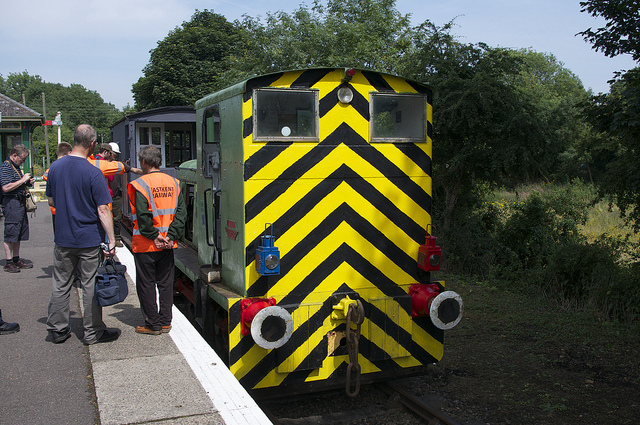

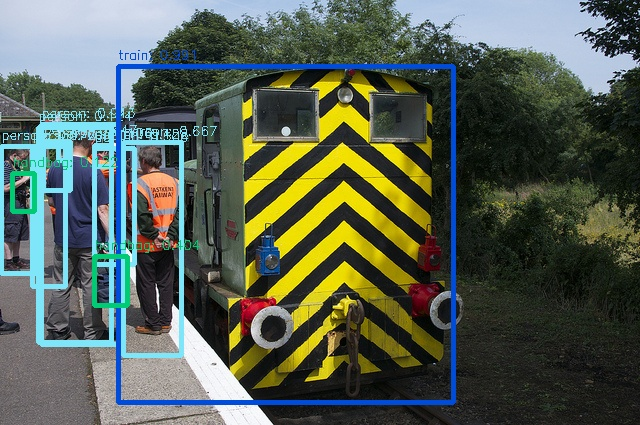

In [13]:
from IPython.display import Image, display_jpeg
display_jpeg(Image('./imgs/COCO_train2014_000000000659.jpg'))
display_jpeg(Image('./imgs/COCO_train2014_000000000659_m2det.jpg'))

 ----------------------------------------------------------------------
|                       M2Det Demo Program                             |
 ----------------------------------------------------------------------
The Anchor info: 
{'feature_maps': [64, 32, 16, 8, 4, 2], 'min_dim': 512, 'steps': [8, 16, 32, 64, 128, 256], 'min_sizes': [30.72, 76.8, 168.96, 261.12, 353.28, 445.44], 'max_sizes': [76.8, 168.96, 261.12, 353.28, 445.44, 537.6], 'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3]], 'variance': [0.1, 0.2], 'clip': True}
===> Constructing M2Det model
Loading resume network...
===> Finished constructing and loading model
ok


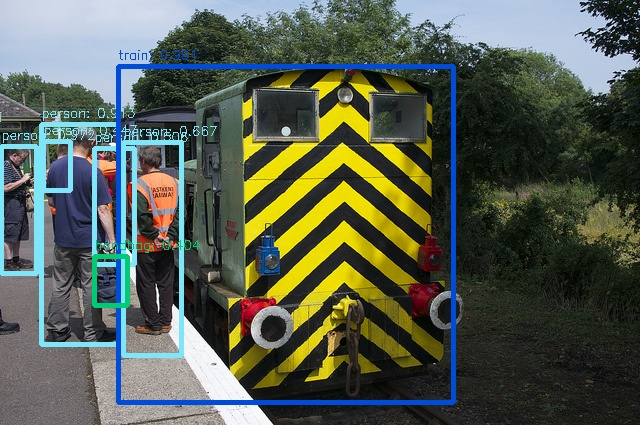

ok


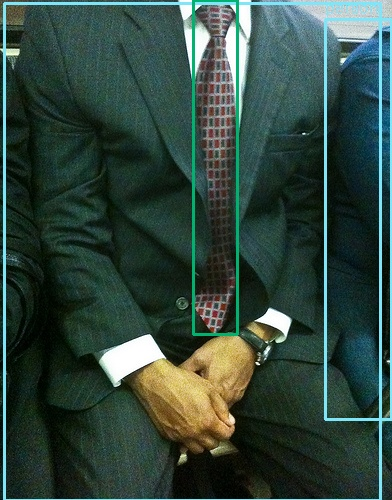

ok


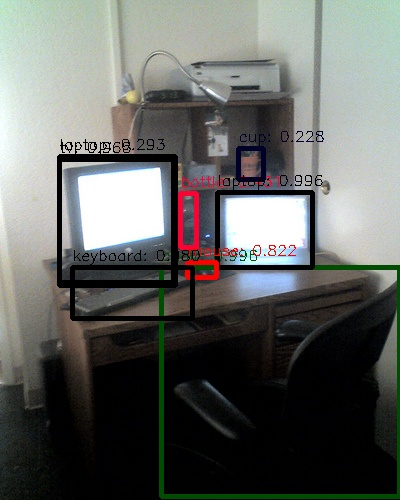

ok


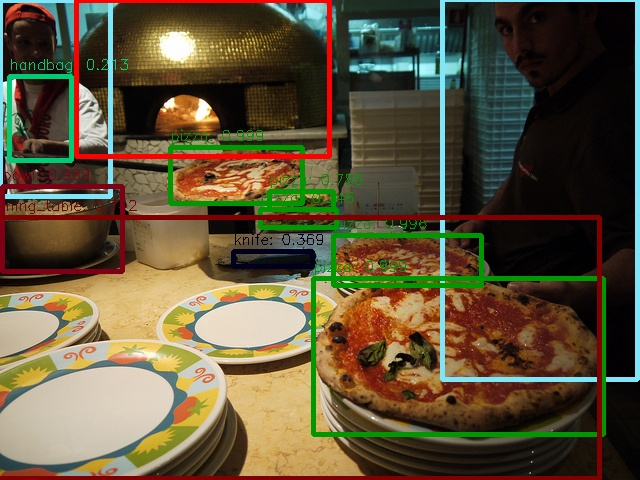

ok


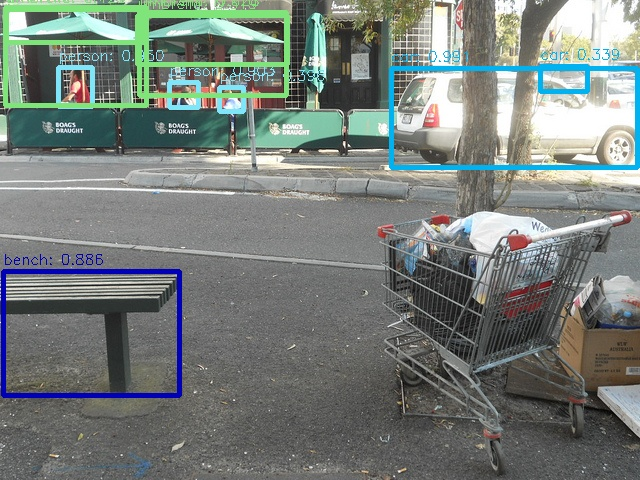

ok


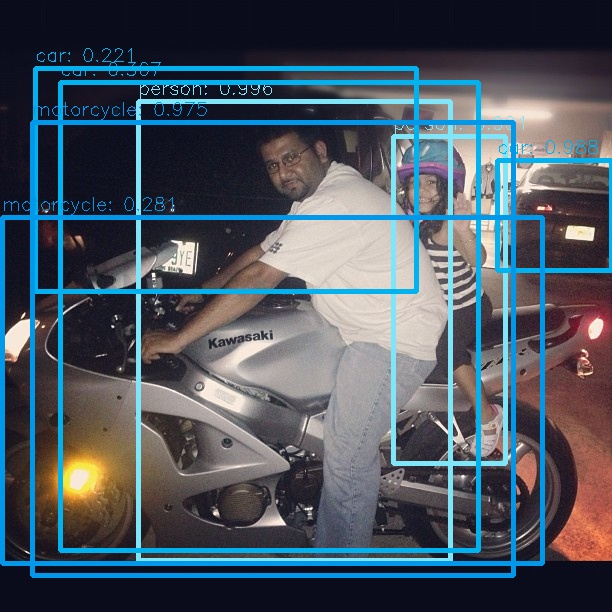

ok


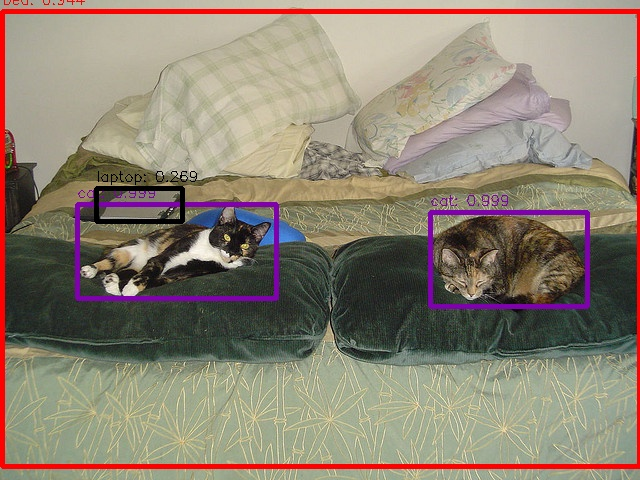

ok


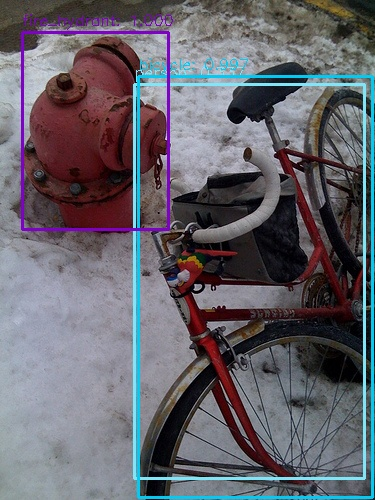

ok


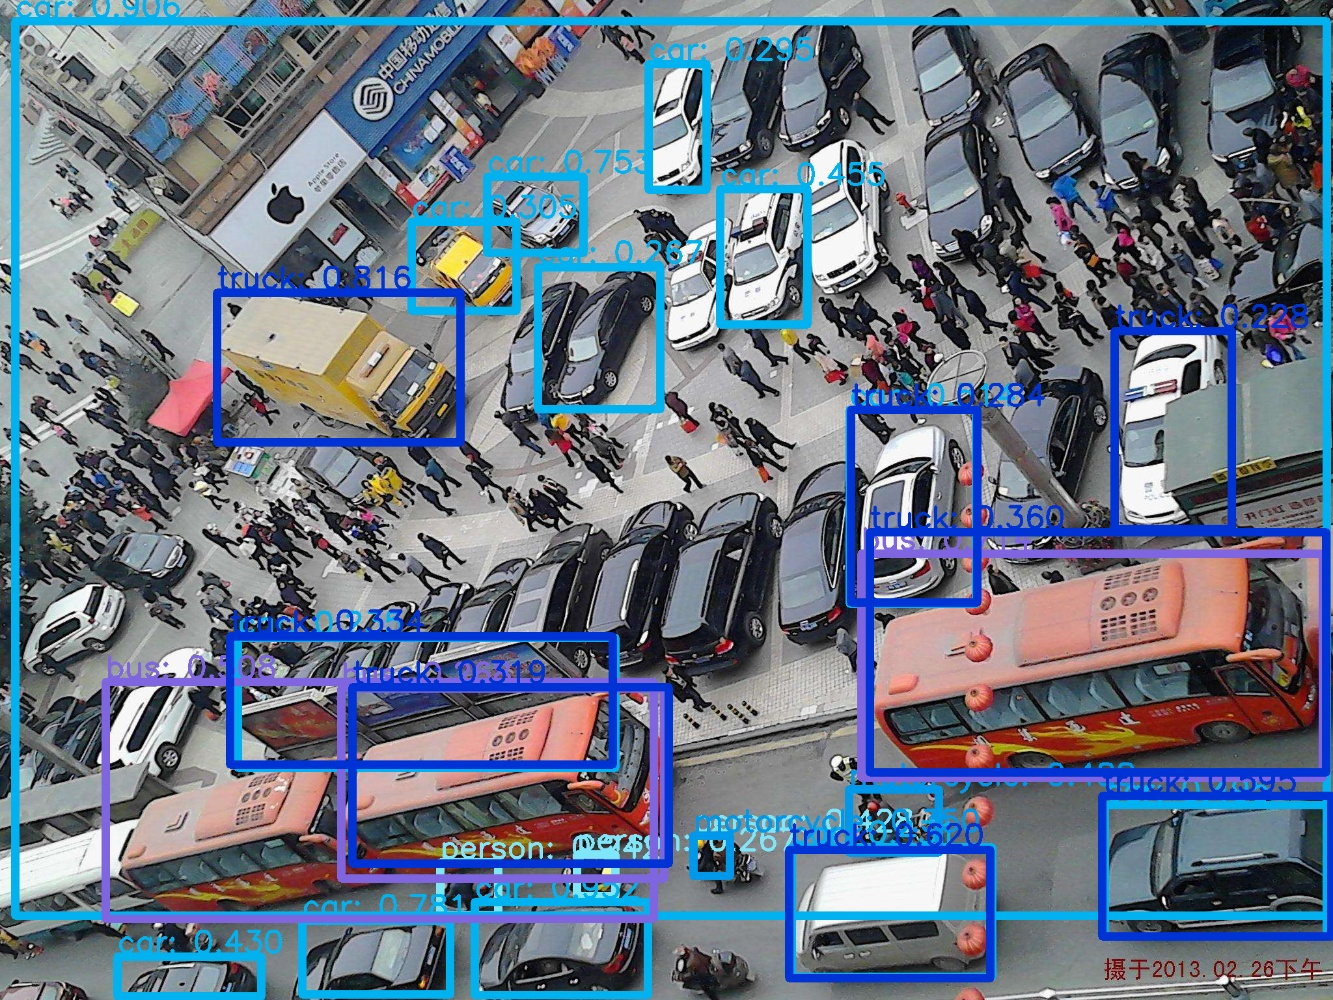

ok


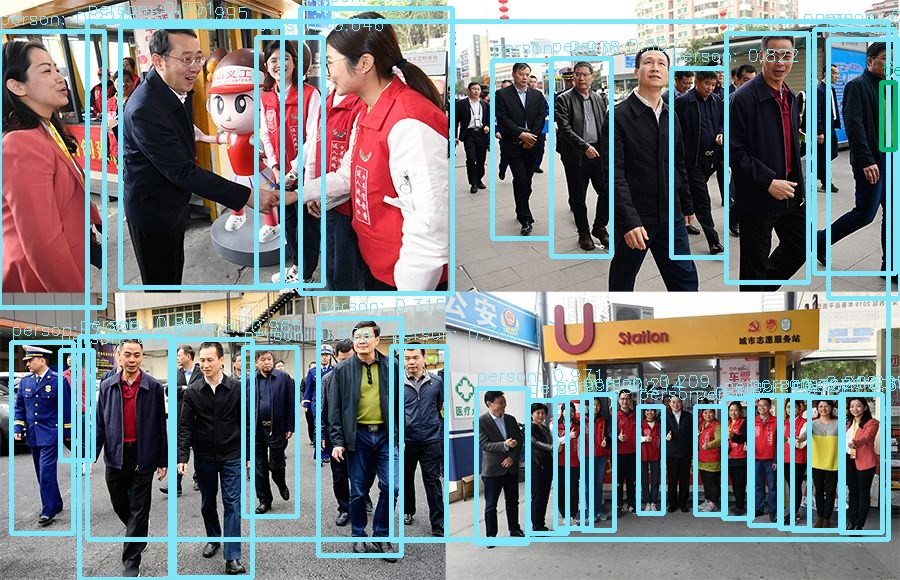

In [14]:
import os
import cv2
import numpy as np
from torch.multiprocessing import Pool
from utils.nms_wrapper import nms
from utils.timer import Timer
from configs.CC import Config
import argparse
from layers.functions import Detect, PriorBox
from m2det import build_net
from data import BaseTransform
from utils.core import *
from utils.pycocotools.coco import COCO
from IPython.display import Image, display_jpeg

parser = argparse.ArgumentParser(description='M2Det Testing')
parser.add_argument('-c', '--config', default='configs/m2det512_vgg.py', type=str)
parser.add_argument('-f', '--directory', default='imgs/', help='the path to demo images')
parser.add_argument('-m', '--trained_model', default='weights/m2det512_vgg.pth', type=str, help='Trained state_dict file path to open')
parser.add_argument('--show', action='store_true', help='Whether to display the images')
args = parser.parse_args()

# -c=configs/m2det512_vgg.py -m=weights/m2det512_vgg.pth --show

print_info(' ----------------------------------------------------------------------\n'
           '|                       M2Det Demo Program                             |\n'
           ' ----------------------------------------------------------------------', ['yellow','bold'])

global cfg
cfg = Config.fromfile(args.config)
anchor_config = anchors(cfg)
print_info('The Anchor info: \n{}'.format(anchor_config))
priorbox = PriorBox(anchor_config)
net = build_net('test',
                size = cfg.model.input_size,
                config = cfg.model.m2det_config)
init_net(net, cfg, args.trained_model)
print_info('===> Finished constructing and loading model',['yellow','bold'])
net.eval()
with torch.no_grad():
    priors = priorbox.forward()
    if cfg.test_cfg.cuda:
        net = net.cuda()
        priors = priors.cuda()
        cudnn.benchmark = True
    else:
        net = net.cpu()
_preprocess = BaseTransform(cfg.model.input_size, cfg.model.rgb_means, (2, 0, 1))
detector = Detect(cfg.model.m2det_config.num_classes, cfg.loss.bkg_label, anchor_config)

def _to_color(indx, base):
    """ return (b, r, g) tuple"""
    base2 = base * base
    b = 2 - indx / base2
    r = 2 - (indx % base2) / base
    g = 2 - (indx % base2) % base
    return b * 127, r * 127, g * 127
base = int(np.ceil(pow(cfg.model.m2det_config.num_classes, 1. / 3)))
colors = [_to_color(x, base) for x in range(cfg.model.m2det_config.num_classes)]
cats = [_.strip().split(',')[-1] for _ in open('data/coco_labels.txt','r').readlines()]
labels = tuple(['__background__'] + cats)

def draw_detection(im, bboxes, scores, cls_inds, thr=0.2):
    imgcv = np.copy(im)
    h, w, _ = imgcv.shape
    for i, box in enumerate(bboxes):
        if scores[i] < thr:
            continue
        cls_indx = int(cls_inds[i])
        box = [int(_) for _ in box]
        thick = int((h + w) / 300)
        cv2.rectangle(imgcv,
                      (box[0], box[1]), (box[2], box[3]),
                      colors[cls_indx], thick)
        mess = '%s: %.3f' % (labels[cls_indx], scores[i])
        cv2.putText(imgcv, mess, (box[0], box[1] - 7),
                    0, 1e-3 * h, colors[cls_indx], thick // 3)

    return imgcv

im_path = '/content/M2Det/imgs'#args.directory
im_fnames = sorted((fname for fname in os.listdir(im_path) if os.path.splitext(fname)[-1] == '.jpg'))
im_fnames = (os.path.join(im_path, fname) for fname in im_fnames)
for i, fname in enumerate(im_fnames):
    if 'm2det' in fname: continue # ignore the detected images
    image = cv2.imread(fname, cv2.IMREAD_COLOR)
    w,h = image.shape[1],image.shape[0]
    img = _preprocess(image).unsqueeze(0)
    if cfg.test_cfg.cuda:
        img = img.cuda()
    scale = torch.Tensor([w,h,w,h])
    out = net(img)
    boxes, scores = detector.forward(out, priors)
    boxes = (boxes[0]*scale).cpu().numpy()
    scores = scores[0].cpu().numpy()
    allboxes = []
    for j in range(1, cfg.model.m2det_config.num_classes):
        inds = np.where(scores[:,j] > cfg.test_cfg.score_threshold)[0]
        if len(inds) == 0:
            continue
        c_bboxes = boxes[inds]
        c_scores = scores[inds, j]
        c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(np.float32, copy=False)
        soft_nms = cfg.test_cfg.soft_nms
        keep = nms(c_dets, cfg.test_cfg.iou, force_cpu = soft_nms) #min_thresh, device_id=0 if cfg.test_cfg.cuda else None)
        keep = keep[:cfg.test_cfg.keep_per_class]
        c_dets = c_dets[keep, :]
        allboxes.extend([_.tolist()+[j] for _ in c_dets])

    allboxes = np.array(allboxes)
    boxes = allboxes[:,:4]
    scores = allboxes[:,4]
    cls_inds = allboxes[:,5]
    #print('\n'.join(['pos:{}, ids:{}, score:{:.3f}'.format('(%.1f,%.1f,%.1f,%.1f)' % (o[0],o[1],o[2],o[3]) \
    #        ,labels[int(oo)],ooo) for o,oo,ooo in zip(boxes,cls_inds,scores)]))
    im2show = draw_detection(image, boxes, scores, cls_inds)
    # print bbox_pred.shape, iou_pred.shape, prob_pred.shape

    if im2show.shape[0] > 1100:
        im2show = cv2.resize(im2show,
                             (int(1000. * float(im2show.shape[1]) / im2show.shape[0]), 1000))
    #if args.show:
    #   cv2.imshow('test', im2show)
    #    cv2.waitKey(5000)
    cv2.imwrite('{}_m2det.jpg'.format(fname.split('.')[0]), im2show)
    print('ok')
    display_jpeg(Image('{}_m2det.jpg'.format(fname.split('.')[0])))
